# EE5175 Lab 7 : DFT, Magnitude-Phase Dominance, and Rotation Property
Author: Kishore Rajendran [EE20B064]

Date: 1 April 2024

In [1]:
# Importing required libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## Implementing 2D DFT using Row-Column Decomposition

Row-Column decomposition : We apply FFT on all the M rows of the image, then we apply FFT on all the N columns to obtain the 2D DFT

In [2]:
def compute_2D_DFT(img):
    # Image dimensions = m x n
    m, n = img.shape
    # First we calculate the DFT of the M rows
    F_int = np.zeros((m, n), dtype=complex)
    for i in range(m):
        F_int[i, :] = np.fft.fft(img[i,:])
    # Now we calculate the DFT of the N columns using these values
    F = np.zeros((m, n), dtype=complex)
    for j in range(n):
        F[:,j] = np.fft.fft(F_int[:,j])
    return F

#### Similarly implementing 2D IDFT
Same as above, here we use ifft instead of fft

In [3]:
def compute_2D_IDFT(F):
    # DFT dimensions = m x n
    m, n = F.shape
    # First we calculate the IDFT of the M rows
    I_int = np.zeros((m, n), dtype=complex)
    for i in range(m):
        I_int[i,:] = np.fft.ifft(F[i,:])
    # Now we calculate the IDFT of the N columns using these values
    I = np.zeros((m, n), dtype=complex)
    for j in range(n):
        I[:,j] = np.fft.ifft(I_int[:,j])
    return I

## Rotation property of 2D DFT 
Assumes center of the image as origin

In [16]:
def compute_rotated_2D_DFT(img, theta):
    # Image dimensions = m x n
    m, n = img.shape
    F = np.zeros((m, n), dtype=complex)
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    kgrid, lgrid = np.meshgrid((np.arange(m) - m//2)/m, (np.arange(n) - n//2)/n, indexing='ij')
    k_vec = np.stack((kgrid, lgrid), axis=-1)
    rk_vec = k_vec @ R.T
    for i in range(m):
        for j in range(n):
            m_vec = np.array([i,j])
            F += img[i,j]*np.exp(-2j*np.pi*np.sum(m_vec * rk_vec, axis=-1))
    return F

#### Functions for rotating an image and bilinear interpolation

In [5]:
# Given the transformed source image pixel coordinates and the image, apply bilinear interpolation to return correct target intensity
def bilinear_interpolation(xs, ys, img):
    xs_i = np.floor(xs)
    ys_i = np.floor(ys)
    a = xs - xs_i
    b = ys - ys_i
    # If the transformed pixel value is out of bounds
    if xs_i < 0 or xs_i >= img.shape[0] - 1 or ys_i < 0 or ys_i >= img.shape[1] - 1:
        return 0
    else:
        # Converting to int, so that the co-ordinates can be used as array indices
        xs_i = int(xs_i)
        ys_i = int(ys_i)
        # Bilinear interpolation
        return (1-a)*(1-b)*img[xs_i, ys_i] + (1-a)*b*img[xs_i, ys_i+1] + a*(1-b)*img[xs_i+1, ys_i] + a*b*img[xs_i+1, ys_i+1]

In [6]:
# Rotate the given image by theta about its center and return the new image
def rotate_img(img, theta):
    # Padding the image with zeros for applying interpolation at the edges of the image
    img = np.pad(img, ((1,1), (1,1)), mode='constant', constant_values=(0,0))
    # Creating an array of zeros which is our target image
    trf_img = np.zeros_like(img)
    # Rotation about the center (theta) 
    for xt in range(img.shape[0]):
        for yt in range(img.shape[1]):
            # Shifting origin to the center of the picture
            xt_shift = xt - img.shape[0]/2
            yt_shift = yt - img.shape[1]/2
            # Applying rotation, then shifting back
            xs = xt_shift*np.cos(theta) - yt_shift*np.sin(theta) + img.shape[0]/2
            ys = xt_shift*np.sin(theta) + yt_shift*np.cos(theta) + img.shape[1]/2
            trf_img[xt, yt] = bilinear_interpolation(xs, ys, img)
    return trf_img

## Q1, 2

In [7]:
# Importing the images as numpy arrays
I1 = np.array(Image.open("fourier.png"))
I2 = np.array(Image.open("fourier_transform.png"))

# Computing 2D DFTs of I1 and I2 to obtain F1 and F2 respectively
F1 = compute_2D_DFT(I1)
F2 = compute_2D_DFT(I2)

In [8]:
# Obtaining magnitude and phase of F1, F2
magF1 = np.abs(F1)
phaseF1 = np.angle(F1)
magF2 = np.abs(F2)
phaseF2 = np.angle(F2)

# Constructing the required DFTs F3 and F4
F3 = magF1*np.exp(1j*phaseF2)
F4 = magF2*np.exp(1j*phaseF1)

# Computing 2D IDFTs of F3 and F4 to obtain I3 and I4 respectively
I3 = np.abs(compute_2D_IDFT(F3))
I4 = np.abs(compute_2D_IDFT(F4))

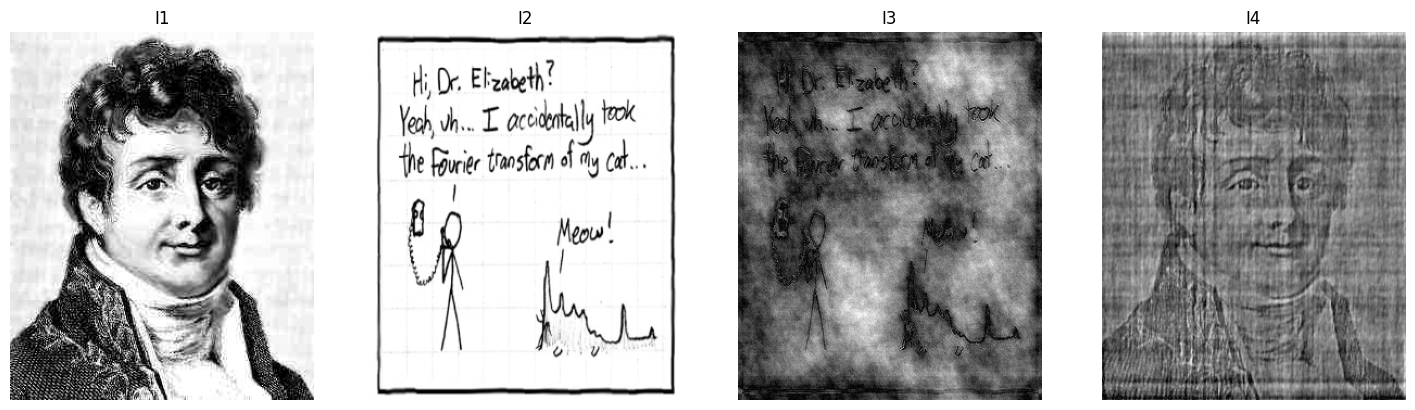

In [9]:
# Plotting I1, I2, I3, I4 side by side
fig, ax = plt.subplots(1, 4, figsize=(18,18))
ax[0].imshow(I1, cmap='gray')
ax[0].set_title("I1")
ax[0].axis('off')

ax[1].imshow(I2, cmap='gray')
ax[1].set_title("I2")
ax[1].axis('off')

ax[2].imshow(I3, cmap='gray')
ax[2].set_title("I3")
ax[2].axis('off')

ax[3].imshow(I4, cmap='gray')
ax[3].set_title("I4")
ax[3].axis('off')

plt.show()

## [Optional] Q3

In [42]:
# Importing the image as numpy array
img = np.array(Image.open("peppers_small.png"))

# Choosing angle of rotation = 0.36 radians
theta = 0.2

# Rotated image
rot_img = rotate_img(img, theta)

# IDFT of rotated DFT
F_img = compute_rotated_2D_DFT(img, theta)
rot_dft_img = np.abs(compute_2D_IDFT(F_img))

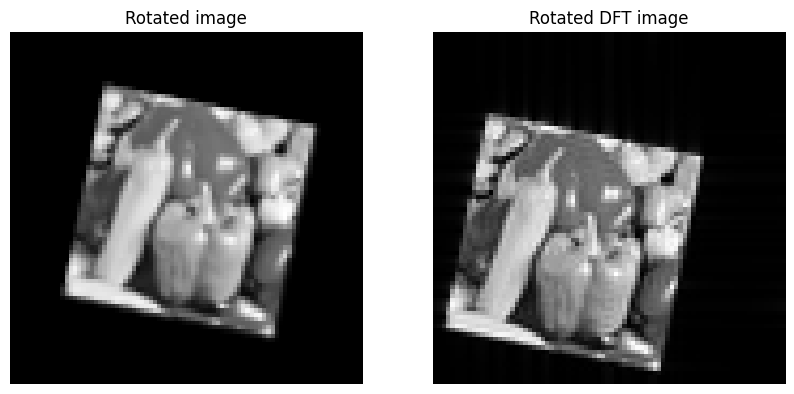

In [43]:
# Plotting the images side by side
fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(rot_img, cmap='gray')
ax[0].set_title("Rotated image")
ax[0].axis('off')

ax[1].imshow(rot_dft_img, cmap='gray')
ax[1].set_title("Rotated DFT image")
ax[1].axis('off')

plt.show()

### Cropping the images then comparing them

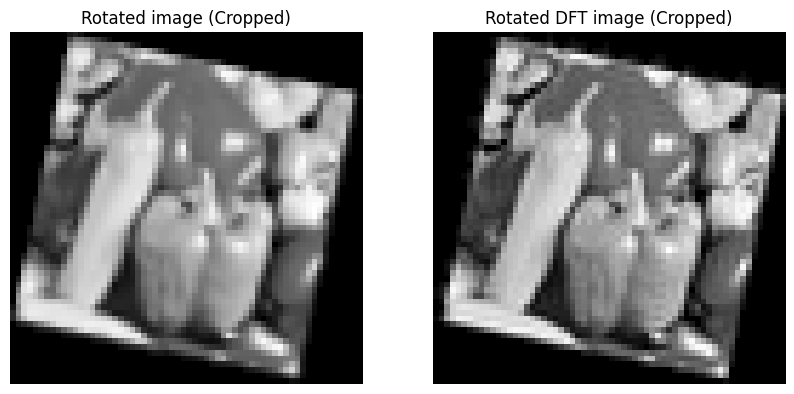

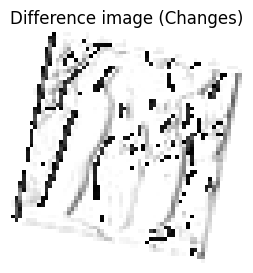

In [54]:
def crop_img(img):
    # Converting all the values to uint8 so that it can be saved
    final_img = np.array(img, dtype=np.uint8)
    final_img[final_img < 10] = 0
    # Removing all the rows and columns which are completely zero (ie: All the black space around our image)
    final_img1 = final_img[:,~np.all(final_img == 0, axis=0)]
    final_img_cropped = final_img1[~np.all(final_img1 == 0, axis=1), :]
    return final_img_cropped

rot_img_crop = crop_img(rot_img)
rot_dft_img_crop = crop_img(rot_dft_img)

# Plotting the images side by side
fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(rot_img_crop, cmap='gray')
ax[0].set_title("Rotated image (Cropped)")
ax[0].axis('off')

ax[1].imshow(rot_dft_img_crop, cmap='gray')
ax[1].set_title("Rotated DFT image (Cropped)")
ax[1].axis('off')

plt.show()

# Detecting Changes
def detect_changes(img1, img2, thresh):
    diff_img = np.abs(img1 - img2)
    # Setting points below chosen threshold to 255 in the diff image
    diff_img[diff_img < thresh] = 255
    return diff_img

changes = detect_changes(rot_img_crop, rot_dft_img_crop, thresh=30)
plt.figure(figsize=(3, 3))
plt.imshow(changes, cmap='gray')
plt.title("Difference image (Changes)")
plt.axis('off')
plt.show()

# Observations
1. Since the 2D DFT operation is separable, we are able to use the row-column decomposition and take row-wise 1D DFTs first and then do the same for all the columns.
2. By using the 1D FFT implementation provided by numpy, we are able to calculate the 2D DFT in $O(N^2 log_2{N})$
3. From the images obtained by interchanging the phase and magnitude components (I3 and I4), we can see the Phase dominance property of the DFT. I3 contains the phase component of I2 and I4 contains the phase component of I1. I3 looks quite similar to I2 and the same holds for I4 and I1. ie. The phase dominates over the magnitude in a DFT operation.
4. The rotated DFT then IDFT gives similar results compared to the rotated image, except for slight changes along the edges present in the image, this is mostly because the rotated DFT doesn't use any kind of interpolation like the rotation transform does.